In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

import xgboost as xgb
from imblearn.pipeline import Pipeline
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

## 1 Read in Train/Test Sets

In [2]:
train = pd.read_csv('~/D2K_BCM_DATASET/4kEnsembleId.tsv', sep='\t',index_col=[0]).transpose()
train.head()

,ENSG00000000003,ENSG00000001036,ENSG00000001084,ENSG00000001629,ENSG00000001631,ENSG00000002586,ENSG00000002933,ENSG00000003400,ENSG00000003509,ENSG00000004468,...,ENSG00000283473,ENSG00000283486,ENSG00000283578,ENSG00000283611,ENSG00000283631,ENSG00000283635,ENSG00000283654,ENSG00000283674,ENSG00000283684,ENSG00000283692
205_2,9.698730,9.007920,11.074547,11.255878,10.578447,9.698730,9.853723,5.876924,9.770795,3.718240,...,0.0,9.213259,0.0,0.000000,0.0,2.014479,0.0,6.376592,0.0,3.339286
251_1,9.181011,8.480250,10.224124,10.854084,10.851306,9.135288,9.296297,5.330312,9.875868,3.708379,...,0.0,8.289156,0.0,2.814728,0.0,2.006454,0.0,6.358106,0.0,2.814728
474_3,8.998180,8.114741,10.315019,10.832309,10.474078,8.410391,9.031668,6.190813,9.971107,3.322830,...,0.0,9.550266,0.0,2.808214,0.0,0.000000,0.0,6.285467,0.0,3.322830
178_4,8.623853,7.775116,10.114775,10.970147,10.669332,8.469199,8.489462,6.511398,10.078450,3.090678,...,0.0,9.065750,0.0,0.000000,0.0,2.587999,0.0,7.421474,0.0,3.090678
313_1,9.265740,8.237808,10.334186,11.156822,10.967349,8.282984,9.324540,5.706331,10.097601,2.887836,...,0.0,9.771254,0.0,0.000000,0.0,2.887836,0.0,6.282053,0.0,4.087801


# 2 Training XGBoost with Grid Search

In [35]:
# create the training matrix and label vector
X_train = train.values
y_train = np.array([int(x[-1]) for x in train.index])

In [4]:
# ## new dataframes for binary classification
train.index = np.array([int(x[-1]) for x in train.index])
idxs13 = (train.index == 1) + (train.index == 3)
train13 = train[idxs13]
idxs14 = (train.index == 1) + (train.index == 4)
train14 = train[idxs14]

In [5]:
# Binary classification groups
X_train13 = train13.values
y_train13 = train13.index
X_train14 = train14.values
y_train14 = train14.index

In [6]:
print("Before oversampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before oversampling, counts of label '2': {}".format(sum(y_train==2)))
print("Before oversampling, counts of label '3': {}".format(sum(y_train==3)))
print("Before oversampling, counts of label '4': {}".format(sum(y_train==4)))

Before oversampling, counts of label '1': 97
Before oversampling, counts of label '2': 160
Before oversampling, counts of label '3': 98
Before oversampling, counts of label '4': 52


In [7]:
# define initial grid search space
grid1 = {
    'max_depth' : range(1,6,2),
    'min_child_weight' : range(1,6,2),
    'reg_alpha' : [1e-5, 0.1, 1],
    'learning_rate' : [0.01, 0.1]
}

search1 = GridSearchCV(estimator=xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1,
                                                  gamma=0, subsample=0.8,colsample_bytree=0.8, objective='multi:softmax',
                                                  n_jobs=4, scale_pos_weight=1, seed=27, num_classes=4, verbose=3),
                      param_grid = grid1, scoring='f1_micro', n_jobs=4, cv=10)

In [8]:
# # uncomment this section if you want to train intermediate models

#starttime = time()
# search1.fit(X_train, y_train)
# endtime = time()
# print('Runtime:',(endtime-starttime)/60, 'minutes')
# search1.scorer_, search1.best_params_, search1.best_score_

In [9]:
best1 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=3, gamma=0, subsample=0.8,
                          colsample_bytree=0.8, objective='multi:softmax', n_jobs=4, scale_pos_weight=1, seed=27,
                          num_classes=4, verbose=3)

grid2 = {
    'subsample' : [0.6, 0.7, 0.8],
    'colsample_bytree' : [0.6, 0.7, 0.8]
}

search2 = GridSearchCV(estimator=best1, param_grid=grid2, scoring='f1_micro', n_jobs=4, cv=10)

In [10]:
# # uncomment this section if you want to train intermediate models

# starttime = time()
# search2.fit(X_train, y_train)
# endtime = time()
# print('Runtime:',(endtime-starttime)/60, 'minutes')
# search2.scorer_, search2.best_params_, search2.best_score_

In [11]:
best2 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=3, gamma=0, subsample=0.7,
                          colsample_bytree=0.8, objective='multi:softmax', n_jobs=4, scale_pos_weight=1, seed=27,
                          num_classes=4, verbose=3)
best2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=4,
              nthread=None, num_classes=4, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, silent=None, subsample=0.7, verbose=3, verbosity=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   29.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   47.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.8min finished


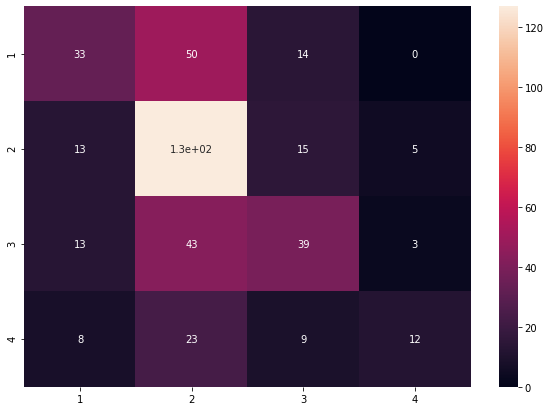

In [12]:
# confusion matrix
y_pred = cross_val_predict(best2, X_train, y_train, cv=StratifiedKFold(n_splits=10), verbose=10)
matrix = confusion_matrix(y_train, y_pred)
df_cm = pd.DataFrame(matrix, index = [i for i in "1234"],
                  columns = [i for i in "1234"])
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, annot=True)

In [13]:
model = Pipeline([
        ('sampling', SMOTE()),
        ('classification', xgb.XGBClassifier())
    ])


param_dist = {'classification__learning_rate' : [0.1],
              'classification__n_estimators' : [100],
              'classification__subsample': [0.6, 0.7, 0.8],
              'classification__max_depth': [5],
              'classification__colsample_bytree': [0.6, 0.7, 0.8],
              'classification__min_child_weight': [3],
              'classification__n_jobs' : [4],
              'classification__objective' : ['multi:softmax'],
              'classification__num_classes' : [4],
              'classification__seed' : [27],
              'sampling__sampling_strategy': ['not majority', 'minority'],
              'sampling__random_state' : [7]
             }

best_param_dist = {'classification__learning_rate' : [0.1],
              'classification__n_estimators' : [100],
              'classification__subsample': [0.8],
              'classification__max_depth': [5],
              'classification__colsample_bytree': [0.6],
              'classification__min_child_weight': [3],
              'classification__n_jobs' : [4],
              'classification__objective' : ['multi:softmax'],
              'classification__num_classes' : [4],
              'classification__seed' : [27],
              'sampling__sampling_strategy': ['not majority'],
              'sampling__random_state' : [7]
             }

# uncomment this section if you want to train intermediate models

smote_search = GridSearchCV(model, best_param_dist, cv=10, n_jobs=4, scoring='f1_micro')
starttime = time()
smote_search.fit(X_train, y_train)
endtime = time()
print('Runtime:',(endtime-starttime)/60, 'minutes')
smote_search.scorer_, smote_search.best_params_, smote_search.best_score_

Runtime: 2.9294827898343403 minutes


(make_scorer(f1_score, pos_label=None, average=micro),
 {'classification__colsample_bytree': 0.6,
  'classification__learning_rate': 0.1,
  'classification__max_depth': 5,
  'classification__min_child_weight': 3,
  'classification__n_estimators': 100,
  'classification__n_jobs': 4,
  'classification__num_classes': 4,
  'classification__objective': 'multi:softmax',
  'classification__seed': 27,
  'classification__subsample': 0.8,
  'sampling__random_state': 7,
  'sampling__sampling_strategy': 'not majority'},
 0.5159756097560976)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:  2.1min remaining:  2.1min
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:  2.2min remaining:   55.6s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  2.7min finished


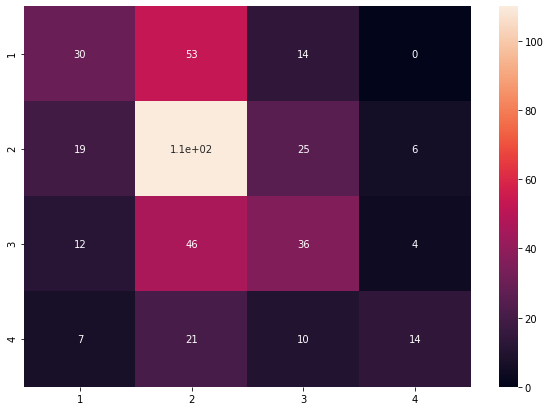

In [14]:
# confusion matrix on SMOTE oversampled model
smotemodel = Pipeline([
        ('sampling', SMOTE(sampling_strategy='not majority')),
        ('classification', xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=3, gamma=0,
                          subsample=0.8, colsample_bytree=0.6, objective='multi:softmax', n_jobs=4, seed=27,
                          num_classes=4, verbose=3))
])
smote_y_pred = cross_val_predict(smotemodel, X_train, y_train, cv=StratifiedKFold(n_splits=10), verbose=10, n_jobs=4)

matrix = confusion_matrix(y_train, smote_y_pred)
df_cm = pd.DataFrame(matrix, index = [i for i in "1234"],
                  columns = [i for i in "1234"])
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, annot=True)

In [15]:
# binary classifier on just groups 1 and 3
binary = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=3, gamma=0, subsample=0.7,
                          colsample_bytree=0.8, objective='binary:logistic', scale_pos_weight=1, seed=27,
                          num_classes=4, verbose=3)
binsearch = GridSearchCV(binary, param_grid={'learning_rate' : [0.1]}, cv=StratifiedKFold(n_splits=10), n_jobs=4, scoring='f1')
starttime = time()
binsearch.fit(X_train13, y_train13)
endtime = time()
print('Runtime:',(endtime-starttime)/60, 'minutes')

# binary classifier accuracy
binsearch.best_score_

Runtime: 0.3763748049736023 minutes


0.659599773478492

In [16]:
# binary classifier on just groups 1 and 4
binsearch2 = GridSearchCV(binary, param_grid={'learning_rate' : [0.1]}, cv=StratifiedKFold(n_splits=10), n_jobs=4, scoring='f1')
starttime = time()
binsearch2.fit(X_train14, y_train14)
endtime = time()
print('Runtime:',(endtime-starttime)/60, 'minutes')

# binary classifier accuracy
binsearch2.best_score_

Runtime: 0.19061556657155354 minutes


0.8181593311341595

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    7.2s remaining:    7.2s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    7.6s remaining:    3.2s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   11.1s finished


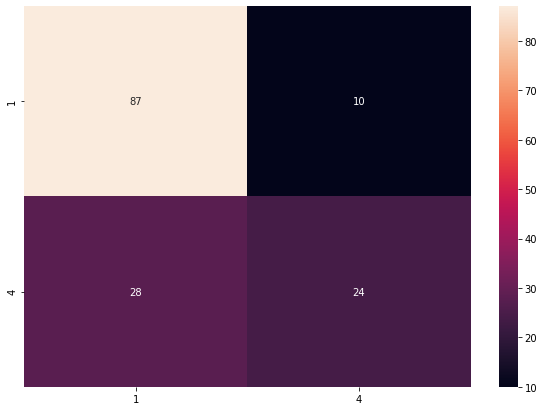

In [17]:
# binary classification confusion matrix
binary_pred = cross_val_predict(binary, X_train14, y_train14, cv=StratifiedKFold(n_splits=10), verbose=10, n_jobs=4)
matrix = confusion_matrix(y_train14, binary_pred)
df_cm = pd.DataFrame(matrix, index = [i for i in "14"],
                  columns = [i for i in "14"])
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, annot=True)

In [18]:
# binary classifier with SMOTE oversampling
smotebin = Pipeline([
        ('sampling', SMOTE(sampling_strategy='minority')),
        ('classification', xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=3, gamma=0, subsample=0.7,
                          colsample_bytree=0.8, objective='binary:logistic', scale_pos_weight=1, seed=27,
                          num_classes=4, verbose=3))
])
binsmote = GridSearchCV(smotebin, param_grid={'sampling__sampling_strategy' : ['minorty', 'not majority']}, cv=StratifiedKFold(n_splits=10), n_jobs=4, scoring='f1')
starttime = time()
binsmote.fit(X_train14, y_train14)
endtime = time()
print('Runtime:',(endtime-starttime)/60, 'minutes')

# binary classifier accuracy with SMOTE oversampling
binsmote.best_score_

Runtime: 0.2819911042849223 minutes


0.8142565900918305

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    9.1s remaining:    9.1s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    9.3s remaining:    3.9s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   12.5s finished


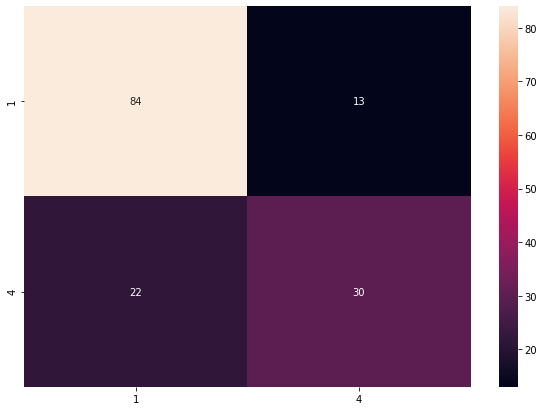

In [19]:
# confusion matrix for SMOTE oversampling
binary_pred2 = cross_val_predict(smotebin, X_train14, y_train14, cv=StratifiedKFold(n_splits=10), verbose=10, n_jobs=4)
matrix = confusion_matrix(y_train14, binary_pred2)
df_cm = pd.DataFrame(matrix, index = [i for i in "14"],
                  columns = [i for i in "14"])
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, annot=True)

In [20]:
b = binsmote.best_estimator_['classification'].feature_importances_
rankings = np.flip(np.argsort(b))
genes = [x for x in rankings if b[x] > 0]
np.intersect1d(np.array(['POU2AF1', 'MOXD1', 'PMAIP1', 'SLCO3A1', 'C2', 'CFB', 'TIMP3']),train14.columns[genes])

array([], dtype=object)

# 3 XGB parameters and gene ranking

<function matplotlib.pyplot.show(*args, **kw)>

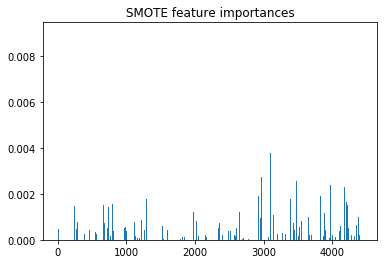

In [21]:
# plot the genes by feature strength in SMOTE model
s = smote_search.best_estimator_['classification'].feature_importances_
plt.bar(range(len(s)), s)
plt.title('SMOTE feature importances')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

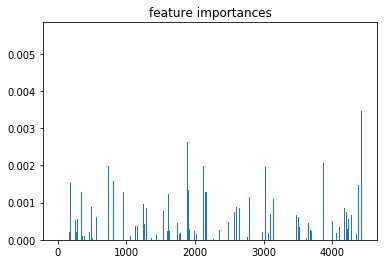

In [22]:
# plot the genes by feature strength in non-SMOTE model
f = best2.feature_importances_
plt.bar(range(len(f)), f)
plt.title('feature importances')
plt.show

In [23]:
# rank features by importance
rankings = np.flip(np.argsort(f))
bestgenes = [x for x in rankings if f[x] > 0.001]

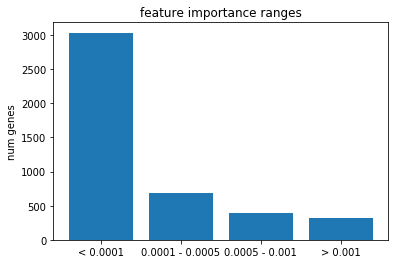

In [25]:
# feature importance histogram
hist = {'< 0.0001' : 0,
        '0.0001 - 0.0005' : 0,
        '0.0005 - 0.001' : 0,
        '> 0.001' : 0
       }
for rank in rankings:
    if f[rank] < 0.0001:
        hist['< 0.0001'] += 1
    elif f[rank] < 0.0005:
        hist['0.0001 - 0.0005'] += 1
    elif f[rank] < 0.001:
        hist['0.0005 - 0.001'] += 1
    else:
        hist['> 0.001'] += 1

plt.bar(hist.keys(), hist.values(), width=0.8)
plt.title('feature importance ranges')
plt.ylabel('num genes')
plt.show()

In [26]:
train.columns[rankings]

Index(['ENSG00000198856', 'ENSG00000131143', 'ENSG00000188428',
       'ENSG00000121236', 'ENSG00000076258', 'ENSG00000189181',
       'ENSG00000110848', 'ENSG00000155008', 'ENSG00000114166',
       'ENSG00000160593',
       ...
       'ENSG00000171729', 'ENSG00000171522', 'ENSG00000171476',
       'ENSG00000171469', 'ENSG00000171467', 'ENSG00000171448',
       'ENSG00000171408', 'ENSG00000171262', 'ENSG00000171150',
       'ENSG00000167528'],
      dtype='object', length=4438)

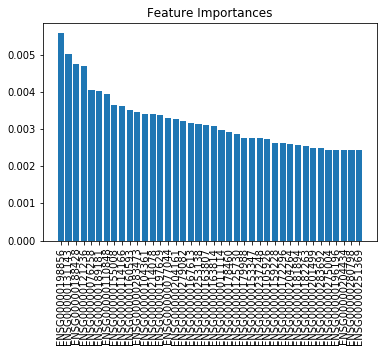

In [28]:
bestgenes = [x for x in rankings if f[x] > 0.001]
plt.bar(train.columns[bestgenes][:40], f[bestgenes][:40], orientation='vertical')
plt.xticks(train.columns[bestgenes][:40], rotation=90)
plt.title('Feature Importances')
plt.show()

In [29]:
# create the feature list for each model
def genes_to_csv(feature_list, model_name):
    ranking = np.flip(np.argsort(feature_list))
    gene_dict = {'score' : feature_list[ranking], 
                 'gene_name' : train.columns[ranking]}
    genedf = pd.DataFrame(data=gene_dict)
    genedf.to_csv(model_name + '_genelist.csv', index=False)

In [30]:
# # This creates the csv files to get genes for pathway analysis.
# # Uncomment this section if you need the csv files

# genes_to_csv(s, 'xgbsmote')
# genes_to_csv(f, 'xgb')